<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/001_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this notebook, we implement [PyTorch RetinaNet](https://github.com/benihime91) for custom dataset. 

We will take the following steps to implement PyTorch RetinaNet on our custom data:
* Install PyTorch RetinaNet along with required dependencies.
* Download Custom Dataset.
* Write Training Configuation yaml file .
* Train  Detection Model .
* Use Trained PyTorch RetinaNet Object Detection For Inference on Test Images.

### **Setting up Colab :**

In [1]:
# What GPU do we have ?
!nvidia-smi

Sat Oct 10 07:29:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# **Install Pytorch Retinanet and Dependencies** :

In [3]:
# Clone the RetinaNet Repo
!git clone https://github.com/benihime91/pytorch_retinanet.git
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet
!echo "[   OK   ] Installed all depedencies "

#Update sys path to enclude the pytorch retinaet modules
import warnings
import os
import sys

warnings.filterwarnings('ignore')
sys.path.append("/content/pytorch_retinanet/")
%load_ext autoreload
%autoreload 2
%matplotlib inline

!echo "[   OK   ] Setup Done "

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1920 (delta 104), reused 101 (delta 40), pack-reused 1730
Receiving objects: 100% (1920/1920), 62.10 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (1268/1268), done.
     |████████████████████████████████| 481kB 5.3MB/s 
     |████████████████████████████████| 276kB 20.5MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
     |████████████████████████████████| 829kB 24.4MB/s 
     |████████████████████████████████| 952kB 5.5MB/s 
[   OK   ] Installed all depedencies 
[   OK   ] Setup Done 


# **Prepare Pytorch Retinanet Object Detection Training Data**

We will use the **[Udacity Self Driving Car Dataset](https://public.roboflow.com/object-detection/self-driving-car)** from RoboFlow. The dataset contains 97,942 labels across 11 classes and 15,000 images


To train on the custom dataset the data needs to be in either **csv** or **pascal-voc** format . Roboflow makes it easier to generate the datasets. We can directly download the datsets in required format.

We will download the dataset in **Pascal-VOC** format and then use in-built methods available in PyTorch Retinanet to convert our data into **csv** format.

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "[YOUR LINK HERE]" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [5]:
#Set up paths 

#Path to where the Images are stored
IMAGE_PATH = "/content/export"
#Path to where annotations are stored
ANNOT_PATH = "/content/export"

In [11]:
import pandas as pd
from utils.pascal import convert_annotations_to_df
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm.auto import tqdm

pd.set_option("display.max_colwidth", None)
np.random.seed(123)

## **Generate csv file from XML Annotations:**

In [13]:
#convert xml files to pandas DataFrames
train_df = convert_annotations_to_df(ANNOT_PATH, IMAGE_PATH, image_set="train")
!echo "[   DONE  ] DataFrame(s) Generated !"


def remove_invalid_annots(df):
    """
    Removes annotaitons where xmax, ymax < xmin,ymin
    from the given dataframe
    """
    df = df[df.xmax > df.xmin]
    df = df[df.ymax > df.ymin]
    df.reset_index(inplace=True, drop=True)
    return df

# removing annotations that are not valid annotations
!echo "[   INFO  ] Removing invalid annotations ... "
train_df = remove_invalid_annots(train_df)
!echo "[   DONE  ] OK !"

[   DONE  ] DataFrame(s) Generated !
[   INFO  ] Removing invalid annotations ... 
[   DONE  ] OK !


In [15]:
#We need to split the dataset in train, validation and test datasets
## TODO : Find a better way to do this function. Function is very slow with large number of annotations

def split_data(df1, size=0.3):
    """
    Splits the given data according to
    unique image ids into two dataframes
    train and test . 

    Args:
        df1  : dataframe to be split
        size : size of the test set, train set will be of size (1-size) 
    """
    _ids = df1.filename.unique()
    _trn_ids, _test_ids = train_test_split(_ids, test_size=size)
    
    print("[   INFO  ] Creating Splits ... ")
    
    df1["split"] = 0

    print("[   INFO  ] Segregating the Data ... ")
    for i,idx in enumerate(tqdm(df1.filename.values, leave=True)):
        
        if idx in set(_trn_ids)  : 
            df1["split"][i] = "train"

        elif idx in set(_test_ids) : 
            df1["split"][i] = "test"

    _trn, _test = df1.loc[df1["split"] == "train"], df1.loc[df1["split"] == "test"]
    
    _trn, _test = _trn.reset_index(drop=True), _test.reset_index(drop=True)
    
    _trn.drop(columns=["split"],inplace=True)
    _test.drop(columns=["split"], inplace=True)
    
    print("[   DONE  ] OK !")

    return _trn, _test


#Train/Test Split
train_df, test_df = split_data(train_df, size=0.3)
#Test/Validation Split
test_df, val_df   = split_data(test_df, size=0.5)


!echo "[   INFO  ] Num training images : {len(train_df.filename.unique())}"
!echo "[   INFO  ] Num validation images : {len(val_df.filename.unique())}"
!echo "[   INFO  ] Num test images : {len(test_df.filename.unique())}"

[   INFO  ] Creating Splits ... 
[   INFO  ] Segregating the Data ... 



[   DONE  ] OK !
[   INFO  ] Creating Splits ... 
[   INFO  ] Segregating the Data ... 



[   DONE  ] OK !
[   INFO  ] Num training images : 9267
[   INFO  ] Num validation images : 1986
[   INFO  ] Num test images : 1986


### **CSV Files are as follows :**

In [16]:
train_df.head()

filename  ...  labels
0  /content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg  ...       2
1  /content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg  ...       2
2  /content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg  ...       2
3  /content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg  ...       2
4  /content/export/1478732571566312422_jpg.rf.cdc162b6bd1b61bb7c69fe96a10806d5.jpg  ...       2

[5 rows x 9 columns]

In [17]:
val_df.head()

filename  ...  labels
0  /content/export/1478732513071153506_jpg.rf.3ad9de6cd0ad1a7e603faff6d65ff4bd.jpg  ...       2
1  /content/export/1478732513071153506_jpg.rf.3ad9de6cd0ad1a7e603faff6d65ff4bd.jpg  ...       2
2  /content/export/1478732513071153506_jpg.rf.3ad9de6cd0ad1a7e603faff6d65ff4bd.jpg  ...       2
3  /content/export/1478732513071153506_jpg.rf.3ad9de6cd0ad1a7e603faff6d65ff4bd.jpg  ...       2
4  /content/export/1478732513071153506_jpg.rf.3ad9de6cd0ad1a7e603faff6d65ff4bd.jpg  ...       2

[5 rows x 9 columns]

In [18]:
test_df.head()

filename  ...  labels
0  /content/export/1478900087026729507_jpg.rf.4c25c1c26a1981acd18d9ad8345db7f1.jpg  ...       2
1  /content/export/1478900087026729507_jpg.rf.4c25c1c26a1981acd18d9ad8345db7f1.jpg  ...       2
2  /content/export/1478900087026729507_jpg.rf.4c25c1c26a1981acd18d9ad8345db7f1.jpg  ...       2
3  /content/export/1478900087026729507_jpg.rf.4c25c1c26a1981acd18d9ad8345db7f1.jpg  ...       2
4  /content/export/1478900087026729507_jpg.rf.4c25c1c26a1981acd18d9ad8345db7f1.jpg  ...       2

[5 rows x 9 columns]

In [19]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV = "/content/test_data.csv"

#Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

# **View Images from the Dataset** :

We can use the fn `visualize_boxes_and_labels_on_image_array` from the RetinaNet repo to visualize images and the bounding boxes over them. To use this function we need to first create a Label Map, which is a list that contains all the classes at index corresponding to the integer labels .

##**Let's now generate the Label Map which is used for visualization:**

In [20]:
from utils.pascal import generate_pascal_category_names

LABEL_MAP = generate_pascal_category_names(train_df)
LABEL_MAP

['__background__',
 'biker',
 'car',
 'pedestrian',
 'trafficLight',
 'trafficLight-Green',
 'trafficLight-GreenLeft',
 'trafficLight-Red',
 'trafficLight-RedLeft',
 'trafficLight-Yellow',
 'trafficLight-YellowLeft',
 'truck']

##**Plot images with Bounding boxes over them**:

In [21]:
from utils import visualize_boxes_and_labels_on_image_array
import matplotlib.pyplot as plt

In [22]:
def grab_bbs_(dataframe, index:int):
    """
    Takes in a Pandas DataFrame and a index number
    Returns filename of the image and all the bounding boxes and class_labels
    corresponding the image that is at the given index
    """
    assert index <= len(dataframe), f"[  ERROR  ] Invalid index for dataframe with len: {len(dataframe)}"
    fname = dataframe.filename[index]
    locs = dataframe.loc[dataframe.filename == fname]
    bbs  = locs[["xmin", "ymin", "xmax", "ymax"]].values
    cls  = locs["labels"].values
    return fname, bbs, cls

### **Image from Train Data:**

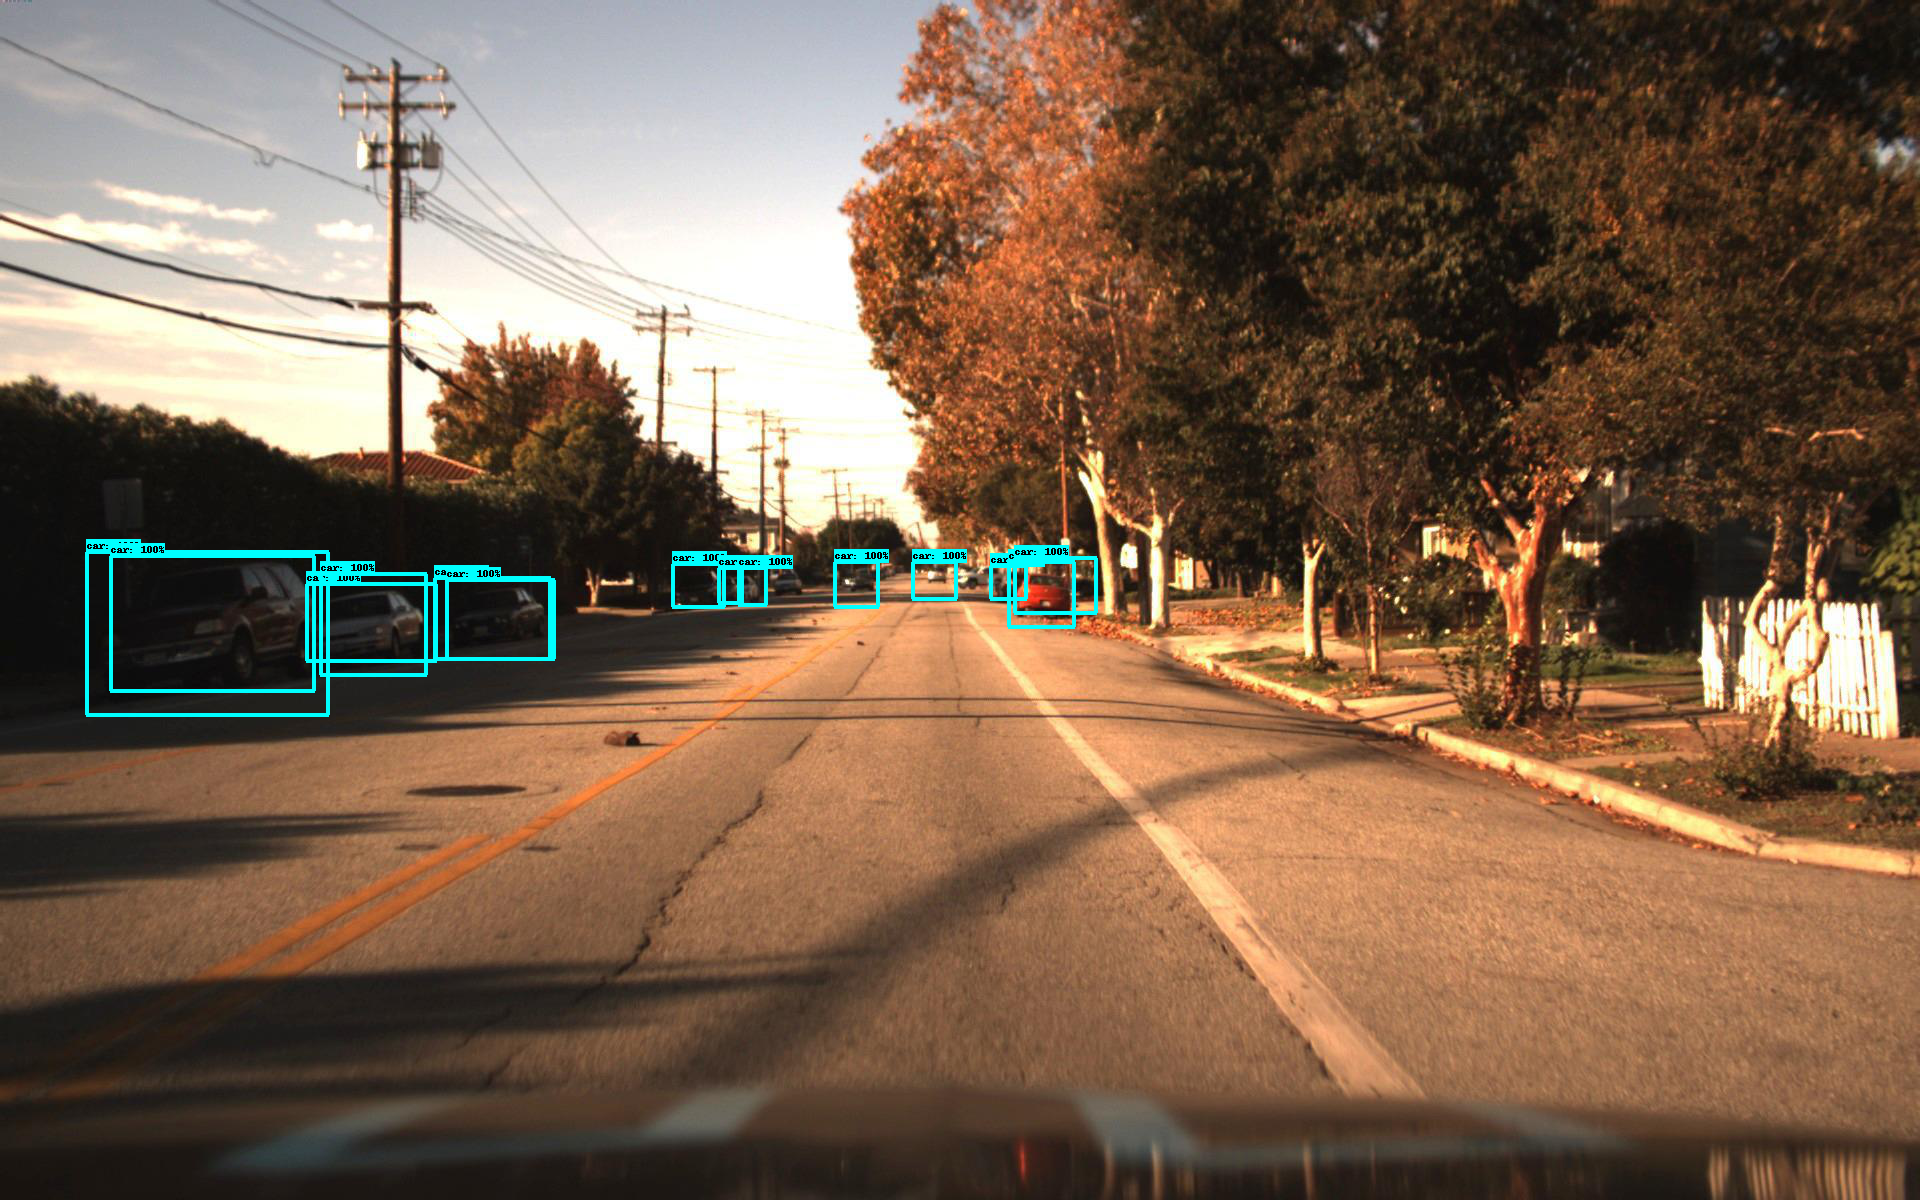

In [30]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(train_df, index=0)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

### **Image from Validation data:**

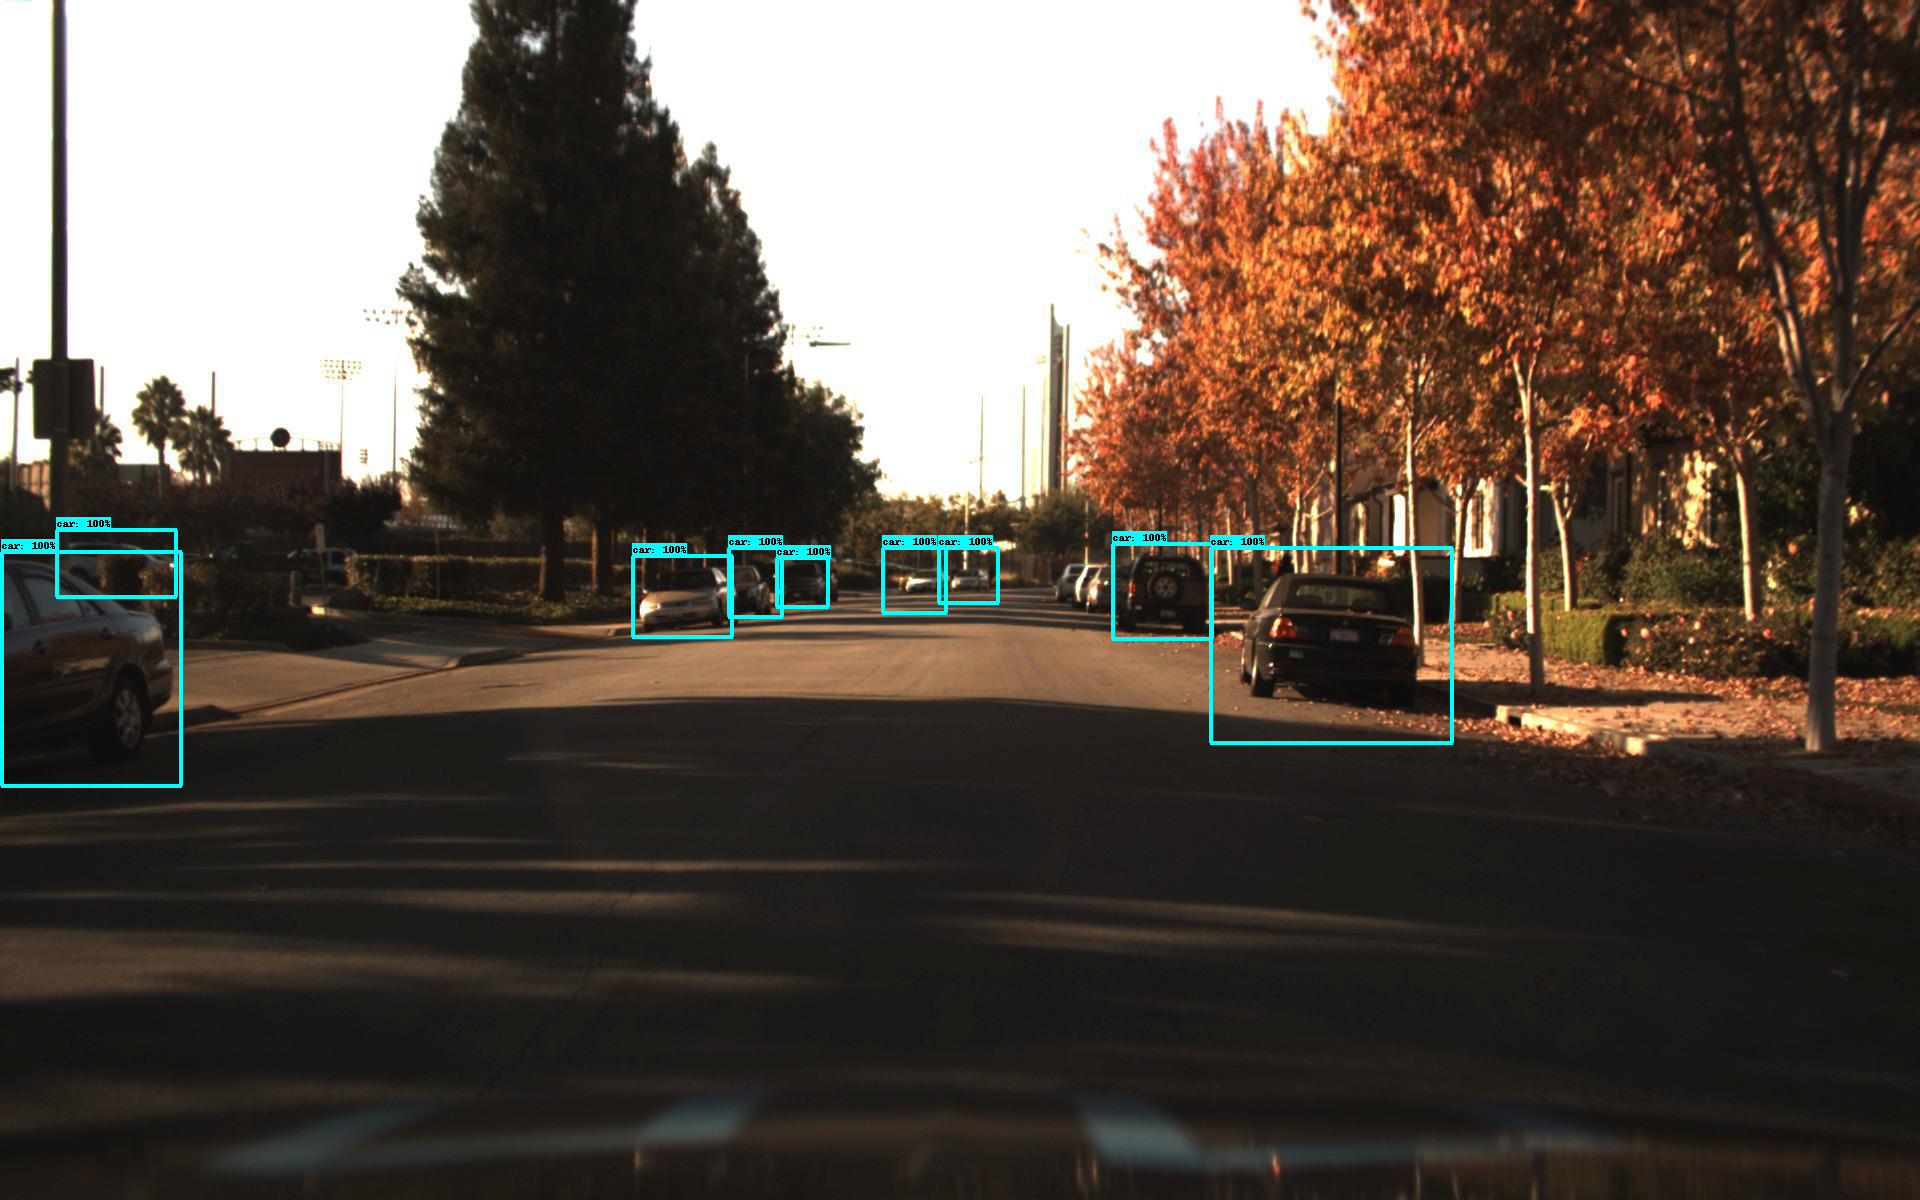

In [29]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(val_df, index=50)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

###**Image from Test Data:**

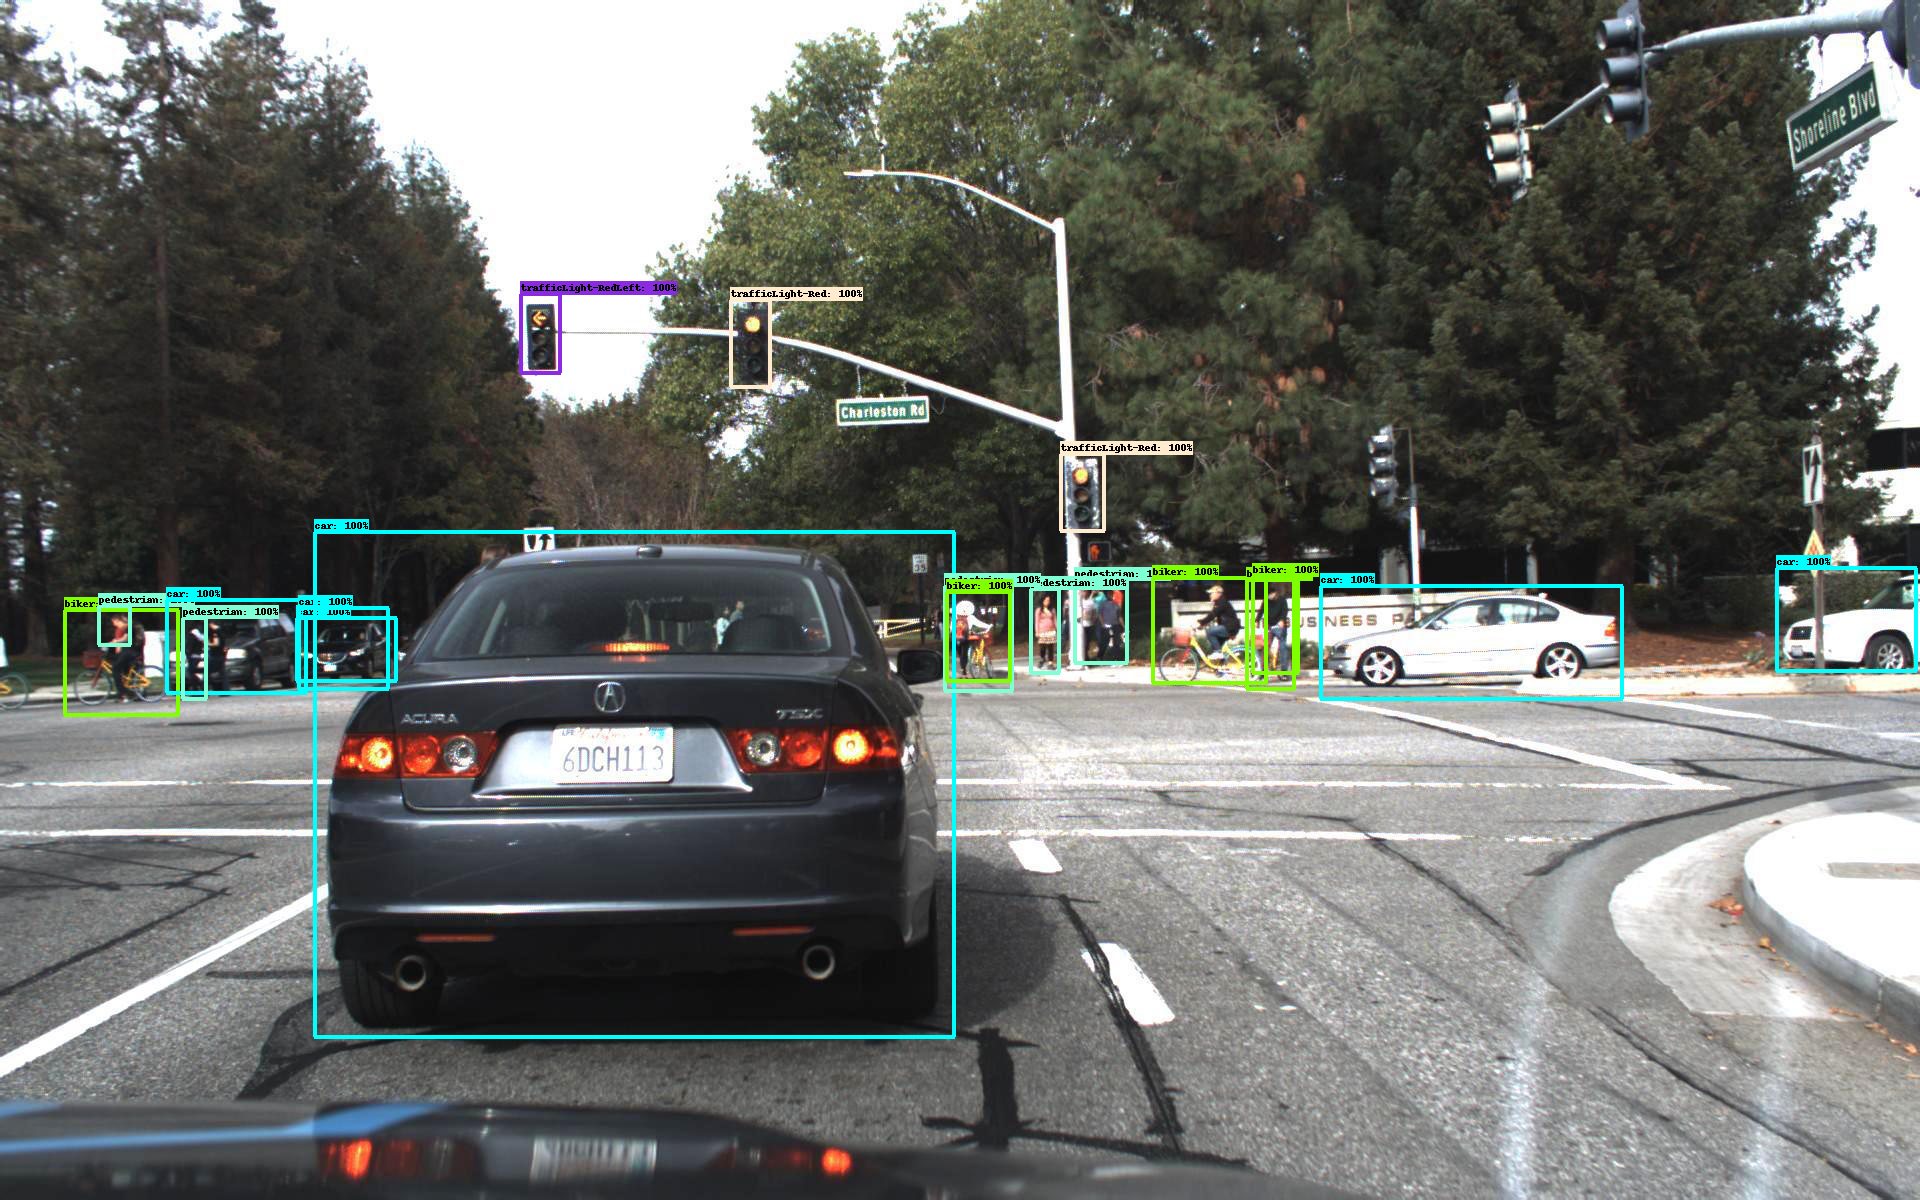

In [28]:
#grab image, boxe and class target
image, boxes, clas = grab_bbs_(test_df, index=100)

#load and normalize the image
image = Image.open(image)
image = np.array(image) / 255.

#draw boxes over the image
image = visualize_boxes_and_labels_on_image_array(
                image=image,
                boxes=boxes, 
                scores=None, 
                classes=clas,
                label_map=LABEL_MAP,
)

# # images are very large so-takes along time to 
# # render . Therefore, plot the images using 
# # matplotlib with a smaller figure size
# plt.figure(figsize=(15,15))
# plt.axis("off")
# plt.imshow(image);
image

#**Configure Custom PyTorch RetianNet Object Detection Training Configuration** :


In [ ]:
#let's look at the config file
!cat /content/pytorch_retinanet/hparams.yaml

In [ ]:
from omegaconf import OmegaConf

#load in the hparams.ymal file using Omegaconf
hparams = OmegaConf.load("/content/pytorch_retinanet/hparams.yaml")
!echo "[  WORKING ] Writing Custom Configuration File .. "
# ========================================================================= #
# MODIFICATION OF THE CONFIG FILE TO FIX PATHS AND DATSET-ARGUEMENTS :
# ========================================================================= #
#specify kind of data to use
hparams.dataset.kind = "csv"
#Paths to the csv files
hparams.dataset.trn_paths   = TRAIN_CSV
hparams.dataset.valid_paths = VALID_CSV
hparams.dataset.test_paths  = TEST_CSV
# number of classes in dataset excluding the 
# "__background__" class
hparams.model.num_classes = len(LABEL_MAP) - 1
#Changing optimizer paramters, 
#Scheduler can also be Optimized in the same way
hparams.optimizer = {
                "class_name": "torch.optim.SGD", 
                "params": {
                    "lr": 8e-02,
                    "momentum": 0.9,
                    "weight_decay" : 0.001,
                    }
            }
hparams.scheduler = {
    "class_name": "torch.optim.lr_scheduler.MultiStepLR",
    "params": {
        "milestones" : [32, 42],
        "gamma" : 0.1,
    }
}

# adding augmentations
hparams.transforms.append(
    {
        "class_name": "albumentations.ShiftScaleRotate",
        "params": {"p": 0.5},
        "interval": "epoch",
        "monitor": False,
    }
)

!echo "[   DONE   ] Configuration File : "
print(OmegaConf.to_yaml(hparams))

#**Instantiate Lightning-Module and Lightning-Trainer**

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import *
from pytorch_lightning.callbacks import *
from model import RetinaNetModel, LogCallback

# seed so that results are reproducible
pl.seed_everything(123)

##**Load in the Lighning-Module using the hparams file modified above :**

In [ ]:
# Instantie lightning-module
litModel = RetinaNetModel(hparams=hparams)

## **Load in the Lighning-Trainer :**

In [ ]:
# ============================================================ #
# INSTANTIATE LIGHTNING-TRAINER with CALLBACKS :
# ============================================================ #
# NOTE: 
# For a list of whole trainer specific arguments see : 
# https://pytorch-lightning.readthedocs.io/en/latest/trainer.html

# Wandb logger
# can use any other logger
save_dir = "/content/logs"
LOGGER = TensorBoardLogger(save_dir="/content/logs")
# Learning-rate Logger
LR_LOGGER = LearningRateLogger(logging_interval="step")

# Model Checkpoint
fname =f"/content/checkpoints/"
os.makedirs(fname, exist_ok=True)
CHECKPOINT_CALLBACK = ModelCheckpoint(fname, mode="min", monitor="val_loss", save_top_k=3,)

# callback for early-stopping
EARLY_STOPPING_CALLBACK = EarlyStopping(mode="min", monitor="val_loss", patience=10,)

# instantiate trainer with arguments from above
trainer = Trainer(precision=16, 
                  max_epochs=50,
                  num_sanity_val_steps=0,
                  gpus=1, 
                  logger=[LOGGER],
                  early_stop_callback=EARLY_STOPPING_CALLBACK, 
                  checkpoint_callback=CHECKPOINT_CALLBACK,
                  callbacks=[LogCallback(), LR_LOGGER], 
                  weights_summary=None,
                  terminate_on_nan=True, 
                  benchmark=True,
                  )

# **Train Custom Pytorch Retinanet Object Detector**:

To train using pytorch-lightning we just need to run `trainer.fit(litModel)`.

Properties (like data, optimzier, scheduler) are already defined in the `litModel` which was loaded using the custom modified `hparams` file.


While `trainer` handles properties like Callbacks, fp_16 training, GPU training ...

In [ ]:
!echo "[   START   ] START TRAINING ... "
trainer.fit(litModel)
!echo "[    END    ] TRAINING COMPLETE ! "
!echo "[    INFO   ] RUN  : %tensorboard --logdir {save_dir} to view TensorBoard Logs "

### **Open TensorBoard Logs :**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {save_dir}

#**Evaluating the trained-model using COCO-API Metrics** : 

In [ ]:
# Evaluations results on the test/ validation dataset(if test dataset is not given)
# using COCO API
!echo "[   START   ] START EVALUATION OF MODEL ON TEST IMAGE USING COCO-API ... "
trainer.test(litModel, ckpt_path="checkpoints/epoch=26.ckpt")
!echo "[    END    ] DONE EVALUATING MODEL ON TEST IMAGE USING COCO-API ! "

# **Export the model weights** :

In [ ]:
import torch

PATH = f"/content/trained_weights.pth"
torch.save(litModel.model.state_dict(), PATH)

#**Load PyTorch Model from the trained Lightning-Module weights :**

In [ ]:
from retinanet import Retinanet

state_dict = torch.load(PATH)

MODEL = Retinanet(num_classes=hparams.model.num_classes, backbone_kind=hparams.model.backbone_kind)
MODEL.load_state_dict(state_dict)

# **Run Inference on Test Images with Custom PyTroch Object Detector**

In [ ]:
from PIL import Image
import numpy as np
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import visualize_boxes_and_labels_on_image_array

@torch.no_grad()
def get_preds(path, threshold=0.6,):
    """
    Generates predictions on the given image from the given path.
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    
    INFER_TRANSFORMS = A.Compose([A.ToFloat(max_value=255.0, always_apply=True),
                                  ToTensorV2(always_apply=True)
                                  ])
    
    TENSOR_IMAGE = INFER_TRANSFORMS(image=image)["image"]
    PREDICTIONS = MODEL.predict([TENSOR_IMAGE])
    #print(PREDICTIONS[0])
    return PREDICTIONS[0]

def detect(image_path, threshold=0.6):
    """
    Generate detections on the image that is present in 
    the given image path

    Args:
        image_path: Path to the input Image
        threshold: Score threshold to filter predictions
        nms_threshold: NMS threshold

    Returns: a PIL image containg the original Image and
             bounding boxes draw over it.
    """
    
    # visualize_boxes_and_labels_on_image_array function
    # expects the pixels values of the image to be in 
    # range [0,1] so be divide the loaded image by 255.0
    # to noramlize the co-ordinates
    # load the image as numpy array
    image = Image.open(image_path)
    image = np.array(image) / 255.
    # Generate predictions for the given image
    preds = get_preds(image_path, threshold,)
    # print(preds)
    # Filter predictions
    boxes, labels, scores = preds["boxes"], preds["labels"], preds["scores"]
    mask = scores > threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    return boxes.numpy(), labels.numpy(), scores.numpy()

In [ ]:
IMAGE, REAL_BOXES, REAL_LABELS = grab_bbs_(test_df, index=4)
IMAGE = Image.open(IMAGE)
IMAGE = np.array(IMAGE) / 255.

#draw boxes over the image
REAL_IMAGE = visualize_boxes_and_labels_on_image_array(
                image=IMAGE,
                boxes=REAL_BOXES, 
                scores=None, 
                classes=REAL_LABELS,
                label_map=LABEL_MAP,
)

REAL_IMAGE

PATH = test_df.filename[4]
THRESHOLD = 0.5

PRED_BOXES, PRED_LABELS, PRED_SCORES = detect(PATH, THRESHOLD,)

PRED_IMAGE = visualize_boxes_and_labels_on_image_array(
                image=IMAGE, 
                boxes=PRED_BOXES, 
                scores=PRED_SCORES,
                classes= PRED_LABELS,
                label_map=LABEL_MAP,
                )

In [ ]:
!echo "[ INFERENCE ] ORIGINAL"

REAL_IMAGE

In [ ]:
!echo "[ INFERENCE ] PREDICTIONS "

PRED_IMAGE